In [1]:
#import libraries
import pandas as pd
import numpy as np
import ta
from ta import add_all_ta_features
from ta.utils import dropna
from ta.momentum import AwesomeOscillatorIndicator
from ta.momentum import AwesomeOscillatorIndicator
from ta.momentum import KAMAIndicator
from ta.momentum import PercentagePriceOscillator
from ta.momentum import ROCIndicator
from ta.momentum import RSIIndicator
from ta.momentum import UltimateOscillator
from ta.volume import ForceIndexIndicator
from ta.volume import AccDistIndexIndicator
from ta.volume import ChaikinMoneyFlowIndicator
from ta.volume import EaseOfMovementIndicator
from ta.volume import MFIIndicator
from ta.volume import VolumePriceTrendIndicator
from ta.volatility import BollingerBands
from ta.volatility import DonchianChannel
from ta.volatility import UlcerIndex
from ta.volatility import KeltnerChannel
from ta.trend import ADXIndicator
from ta.trend import AroonIndicator
from ta.trend import EMAIndicator
from ta.trend import MACD
from ta.trend import MassIndex
import os
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statistics import stdev
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from xgboost import XGBClassifier
import pandas as pd
import datetime as dt
import numpy as np
import random
import json
import pickle
from numpy import abs
from numpy import log
from numpy import sign
from scipy.stats import rankdata
import pandas as pd
from sklearn import preprocessing
import random
from random import sample
random.seed(1)
np.random.seed(1)

#BECAUSE WE ARE ANIMALS
import warnings
warnings.filterwarnings('ignore')

def computeRSI(data, time_window):
    diff = data.diff(1).dropna()  # diff in one field(one day)

    # this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff

    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[diff > 0]

    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[diff < 0]

    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg = up_chg.ewm(com=time_window - 1, min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window - 1, min_periods=time_window).mean()

    rs = abs(up_chg_avg / down_chg_avg)
    rsi = 1 - 1 / (1 + rs)
    return rsi

In [2]:
#plain dataframe read
df = pd.read_csv('prc.csv',index_col='date',parse_dates=True)
df

,gvkey,open,high,low,close,volume
date,,,,,,
1999-01-04,1166,NaN,4.60,4.45,4.50,45145
1999-01-05,1166,NaN,4.60,4.45,4.50,32047
1999-01-06,1166,NaN,5.00,4.60,4.70,550752
1999-01-07,1166,NaN,4.90,4.60,4.85,323750
1999-01-08,1166,NaN,5.60,5.05,5.15,651759
...,...,...,...,...,...,...
2021-02-24,340153,30.50,31.71,30.18,30.39,2018977
2021-02-25,340153,30.90,31.28,30.47,30.48,1461881
2021-02-26,340153,30.08,31.33,29.67,31.25,1850125


In [3]:
times = [3, 4, 5, 8, 12]
df[f'return'] = df[f'close'].pct_change()
df[f'return future'] = df[f'return'].shift(-1)
for time in times:
    df[f'RET {time}'] = df[f'close'].pct_change(time - 1)
    df[f'STD {time}'] = df[f'return'].rolling(time).std()
    df[f'EMA {time}'] = df[f'close'] / df[f'close'].ewm(span=time, adjust=False).mean() - 1
    df[f'SH {time}'] = df[f'return'].rolling(time).mean() / df[f'STD {time}']
#     df[f'RSI {time}'] = computeRSI(df[f'close'], time)

In [4]:
df

,gvkey,open,high,low,close,volume,return,return future,RET 3,STD 3,...,EMA 5,SH 5,RET 8,STD 8,EMA 8,SH 8,RET 12,STD 12,EMA 12,SH 12
date,,,,,,,,,,,,,,,,,,,,,
1999-01-04,1166,NaN,4.60,4.45,4.50,45145,NaN,0.000000,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN
1999-01-05,1166,NaN,4.60,4.45,4.50,32047,0.000000,0.044444,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN
1999-01-06,1166,NaN,5.00,4.60,4.70,550752,0.044444,0.031915,0.044444,NaN,...,0.029197,NaN,NaN,NaN,0.034230,NaN,NaN,NaN,0.037351,NaN
1999-01-07,1166,NaN,4.90,4.60,4.85,323750,0.031915,0.061856,0.077778,0.022916,...,0.040524,NaN,NaN,NaN,0.051526,NaN,NaN,NaN,0.058979,NaN
1999-01-08,1166,NaN,5.60,5.05,5.15,651759,0.061856,0.029126,0.095745,0.015037,...,0.067562,NaN,NaN,NaN,0.088375,NaN,NaN,NaN,0.103353,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-24,340153,30.50,31.71,30.18,30.39,2018977,0.002309,0.002962,-0.033089,0.000000,...,-0.023415,-inf,-0.041325,2.137370,-0.031467,-0.001625,-0.024711,0.0,-0.035304,-inf
2021-02-25,340153,30.90,31.28,30.47,30.48,1461881,0.002962,0.025262,0.005277,0.000000,...,-0.013776,-inf,-0.074400,2.137363,-0.022385,-0.002181,-0.024640,0.0,-0.027593,-inf
2021-02-26,340153,30.08,31.33,29.67,31.25,1850125,0.025262,0.010880,0.028299,0.000000,...,0.007398,-inf,-0.055891,2.137329,0.001797,-0.002973,-0.022215,0.0,-0.002563,inf


In [5]:
df_sample = df
df_sample = df_sample.sort_values(by=['date'])

In [6]:
df = df_sample
df = df.reset_index(drop=True)
dfgv = df #backup because we need the gvkey later

In [217]:
df = dfgv
# Sample x stocks
subset = 10
num_stocks=df['gvkey'].value_counts()
name_list = list(num_stocks.index)
random_keys = sample(name_list,subset)
df_sample = df[df['gvkey'].isin(random_keys)]
df = df_sample

In [218]:
# drop those uncool non-normalized bitches
df = df.drop('volume open high low close gvkey'.split(),axis=1)

In [219]:
df = df.dropna()

In [220]:
# make it a classification problem
df['Target'] = np.where(df['return future'] > 0.00, 1, 0) #play around with this and see the results
y = df['Target']
X = df.drop(['Target','return future'], axis=1)

In [221]:
y.sum() / len(y) #imbalance

0.4293568492964263

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# good set for future grid searches
grid = {
    'max_depth': [1, 2, 3, 4, 6, 9],
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.3, 0.4],
    # 'gamma': [0.0, 0.25, 1, 5],
    # 'colsample_bytree': [0.4, 0.8, 1],
}

xgb = XGBClassifier(
#                     class_weight='balanced',
                    max_depth=2,
                    learning_rate=0.1,
                    gamma=0,
#                     scale_pos_weight=1.5, #forces to give more aggressive positive outcomes
                    verbosity=0)
xgb.fit(X_train, y_train)
predicted_proba = xgb.predict_proba(X_test)

In [227]:
threshold = 0.5 #play around with this and see the results
predictions_pos = (predicted_proba [:,1] > (threshold)).astype('int')

tx_cost = 0.002
df2 = X_test
df2['gvkey'] = dfgv['gvkey']

df2['Predictions Plus'] = predicted_proba[:, 1]
df2['Target Return Future'] = df['return future'] 
df2['Predictions Pos'] = predictions_pos
df2['Pred Pos Return'] = np.where(df2['Predictions Pos'] == 1, df2[f'Target Return Future'] - tx_cost, 0)
strategy_sharpe = np.sqrt(200 * (1440 / 60*24*20)) * (df2['Pred Pos Return'].mean() / df2['Pred Pos Return'].std())
benchsharpe = np.sqrt(200 * (1440 / 60*24*20)) * df2['Target Return Future'].mean() / df2['Target Return Future'].std()
print("NSharpe : ", strategy_sharpe)
print("BSharpe : ", benchsharpe)
df2 = df2.reset_index()

NSharpe :  65.51940446692396
BSharpe :  22.825527468098134


In [228]:
# #look at performance of each stock
# outperformance_count = 0
# stockos = df2['gvkey'].unique()
# for stocki in stockos:
#     df33 = df2[df2['gvkey']==stocki]
#     df33 = df33.reset_index()

#     df33['Strategy'] = (df33['Pred Pos Return'].shift(1) + 1).cumprod()
# #     df33['Strategy'].plot(legend='Strategy')
    
# #     df33['Strategy Market Neutral'] = (df33['Pred All Return'].shift(1) + 1).cumprod()
# #     df33['Strategy Market Neutral'].plot(legend='Strategy Market Neutral')

#     df33['stock'] = (df33['Target Return Future'].shift(1) + 1).cumprod()
#     df33['stock'].plot(legend='stock')
#     plt.show()
#     # Metrics
#     signal_ratio = df33['Predictions Pos'].describe()[1]
#     meanret = df33['Pred Pos Return'].mean() * 10000 * (1/signal_ratio)
    
#     try:
#         strategy_sharpe = df33['Pred Pos Return'].mean() / df33['Pred Pos Return'].std()
#         benchsharpe = df33['return'].mean() / df33['return'].std()
#     except ZeroDivisionError as e:
#         strategy_sharpe = 0
#         benchsharpe = 0
#     if strategy_sharpe > benchsharpe:
#         outperformance_count += 1
#     totret = df33['Pred Pos Return'].sum() * 100
#     n_of_trades = df33['Predictions Pos'].sum()
# #     print(stocki)
# #     print("Sharpe : ", strategy_sharpe)
# #     print("Benchmark Sharpe : ", benchsharpe)
# #     print("Mean Return in bp per Trade: ", meanret)
# #     print("Total Return %: ", totret)
# #     print("Number of trades :", n_of_trades)
    
# print("___________________________________________________")
# print("Outperfomance ratio:", outperformance_count / len(df2['gvkey'].unique()))

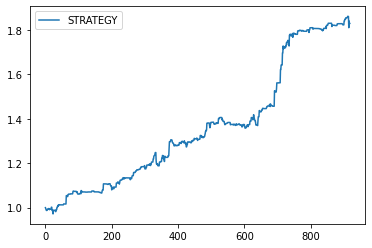

NSharpe :  0.13491145785928121
BSharpe :  0.06755727733025901


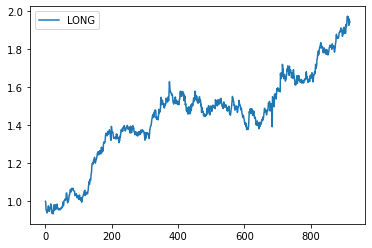

In [229]:
outperformance_count = 0
stockos = df2['gvkey'].unique()
red = pd.DataFrame(0, index=np.arange(len(df2)/len(stockos)), 
                   columns=['Pred Pos Return','Target Return Future'])
red.index = red.index.astype(int)

for stocki in stockos:
    df33 = df2[df2['gvkey']==stocki]
    df33 = df33.reset_index()
    red['buffer'] = df33['Pred Pos Return'].shift(1)
    red['buffer'] = red['buffer'].fillna(0)
    red['Pred Pos Return'] = red['buffer'] + red['Pred Pos Return']
    red['buffer2'] = df33['Target Return Future'].shift(1)
    red['buffer2'] = red['buffer2'].fillna(0)
    red['Target Return Future'] = red['buffer2'] + red['Target Return Future']
    
red[f'Pred Pos Return'] = red[f'Pred Pos Return'] / len(stockos)
red[f'Target Return Future'] = red[f'Target Return Future'] / len(stockos)

red[f'STRATEGY'] = (red['Pred Pos Return'] + 1).cumprod()
red[f'STRATEGY'].plot(legend='STRATEGY')
plt.show()
red[f'LONG'] = (red['Target Return Future'] + 1).cumprod()
red[f'LONG'].plot(legend='LONG')


strategy_sharpe = (red['Pred Pos Return'].mean() / red['Pred Pos Return'].std())
benchsharpe = red['Target Return Future'].mean() / red['Target Return Future'].std()
print("NSharpe : ", strategy_sharpe)
print("BSharpe : ", benchsharpe)

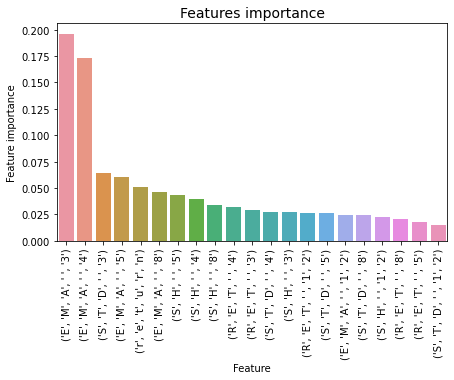

('E', 'M', 'A', ' ', '3')
('E', 'M', 'A', ' ', '4')
('S', 'T', 'D', ' ', '3')
('E', 'M', 'A', ' ', '5')
('r', 'e', 't', 'u', 'r', 'n')
('E', 'M', 'A', ' ', '8')
('S', 'H', ' ', '5')
('S', 'H', ' ', '4')
('S', 'H', ' ', '8')
('R', 'E', 'T', ' ', '4')
('R', 'E', 'T', ' ', '3')
('S', 'T', 'D', ' ', '4')
('S', 'H', ' ', '3')
('R', 'E', 'T', ' ', '1', '2')
('S', 'T', 'D', ' ', '5')
('E', 'M', 'A', ' ', '1', '2')
('S', 'T', 'D', ' ', '8')
('S', 'H', ' ', '1', '2')
('R', 'E', 'T', ' ', '8')
('R', 'E', 'T', ' ', '5')
('S', 'T', 'D', ' ', '1', '2')


In [230]:
import seaborn as sns
tmp = pd.DataFrame({'Feature': X, 'Feature importance': xgb.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

for t in tmp.Feature:
    print(t)